In [13]:
import numpy as np
import cantera as ct
import matplotlib.pyplot as plt
import time

/tmp/ipykernel_4071599/1780454242.py:14: UserWarning: NasaPoly2::validate: 
For species CH2OCH, discontinuity in cp/R detected at Tmid = 500
	Value computed using low-temperature polynomial:  8.393471510000001
	Value computed using high-temperature polynomial: 9.1801039121875

  gas = ct.Solution('JetSurf_1_0.yaml')
/tmp/ipykernel_4071599/1780454242.py:14: UserWarning: NasaPoly2::validate: 
For species CH2OCH, discontinuity in h/RT detected at Tmid = 500
	Value computed using low-temperature polynomial:  42.199147089791666
	Value computed using high-temperature polynomial: 41.961461604875005

  gas = ct.Solution('JetSurf_1_0.yaml')
/tmp/ipykernel_4071599/1780454242.py:14: UserWarning: NasaPoly2::validate: 
For species CH2OCH, discontinuity in s/R detected at Tmid = 500
	Value computed using low-temperature polynomial:  33.70692865946735
	Value computed using high-temperature polynomial: 33.51209988778391

  gas = ct.Solution('JetSurf_1_0.yaml')
/tmp/ipykernel_4071599/1780454242.py:14: 


T_0 = 1600.0 K, P_0 = 1.0 atm, Phi = 1.0
Number of species :   194
Number of reactions :  1459
     t [s]      T [K]          P [Pa]        u [J/kg]
 2.502e-06   1494.350       98715.783  1104662.374657
 5.000e-06   1518.818      101346.172  1104662.374637
 7.500e-06   1555.952      104390.278  1104662.374653
 1.000e-05   1595.328      107443.225  1104662.374647
 1.250e-05   1635.059      110539.085  1104662.374632
 1.500e-05   1679.016      114021.430  1104662.374826
 1.750e-05   1733.103      118361.087  1104662.374622
 2.000e-05   1807.960      124426.862  1104662.374536
 2.250e-05   1936.491      134893.738  1104662.373334
 2.500e-05   2326.807      166537.612  1104662.370518
 2.750e-05   2697.740      196171.035  1104662.370388
 3.000e-05   2738.587      198756.345  1104662.370199
 3.250e-05   2770.607      200688.061  1104662.369921
 3.500e-05   2798.038      202318.595  1104662.369537
 3.750e-05   2822.120      203742.064  1104662.370208
 4.000e-05   2843.342      204991.816  1

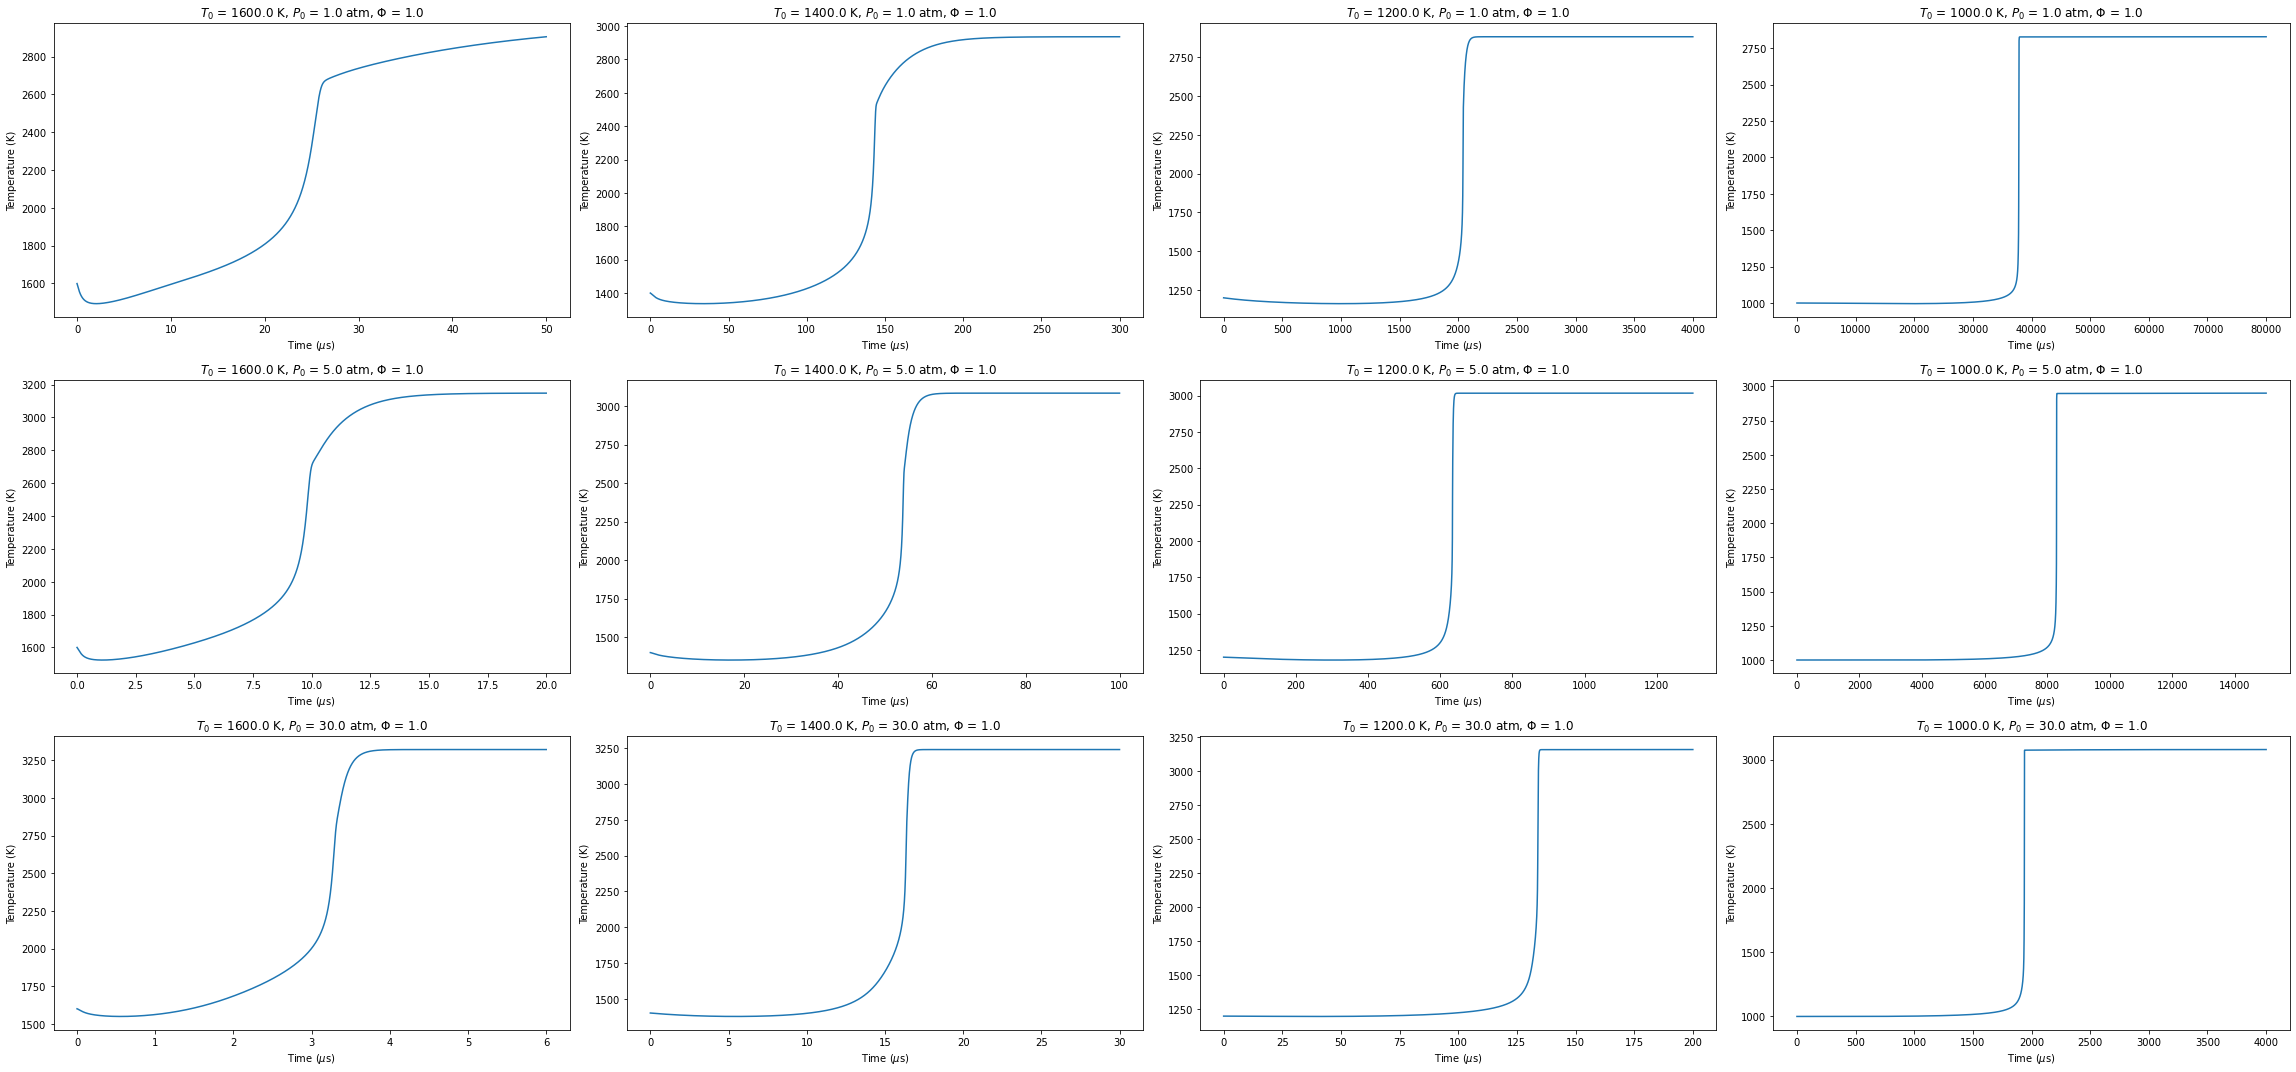

<Figure size 432x288 with 0 Axes>

In [10]:
dts = [2.5e-9, 1.5e-8, 2e-7, 4e-6,
    1e-9, .5e-8, .65e-7, .75e-6,
    3e-10, 1.5e-9, 1e-8, 2e-7]
n_steps= 20000
phi= 1.0
case_idx = 0
plt.figure(figsize=(32, 15))
reaction_rates = []
net_production_rates = []

for init_P in [1.0, 5.0, 30.0]:
    for init_T in [1600.0, 1400.0, 1200.0, 1000.0]:
        dt = dts[case_idx]
        gas = ct.Solution('JetSurf_1_0.yaml')
        gas.TP = init_T, init_P * ct.one_atm
        gas.set_equivalence_ratio(phi=phi, fuel="NC7H16", oxidizer={"O2": 1.0, "N2": 3.76})

        r = ct.IdealGasMoleReactor(contents=gas, name="Batch Reactor") # constant volume reactor
        sim = ct.ReactorNet([r])
        sim.verbose = False
        # if plt_idx != 1:
        # sim.preconditioner = ct.AdaptivePreconditioner() # add preconditioner to the network
        states = ct.SolutionArray(gas, extra=['t'])

        print("\n" + "=" * 60)
        print(f'T_0 = {init_T:4} K, P_0 = {init_P:2} atm, Phi = {phi:.1f}')
        print(f"Number of species : {gas.n_species:5}")
        print(f"Number of reactions : {gas.n_reactions:5}") # number of elementary reactions in the mechanism
        start_time = time.time()

        print('{:>10s} {:>10s} {:>15s} {:>15s}'.format('t [s]', 'T [K]', 'P [Pa]', 'u [J/kg]'))
        ignited = False
        for i in range(n_steps):
            sim.advance(sim.time + dt)
            states.append(r.thermo.state, t=sim.time*1e6)
            if r.T >= init_T + 400. and ignited is False:
                ignited = True
                idt = sim.time*1e6
            reaction_rates.append(r.kinetics.net_rates_of_progress) # elementary reaction rates
            net_production_rates.append(r.kinetics.net_production_rates) # net production rates of species
            if (sim.time // dt) % 1000 == 0:
                print('{:10.3e} {:10.3f} {:15.3f} {:15.6f}'.format(sim.time, r.T, r.thermo.P, r.thermo.u))

        print(f"Simulation time : {time.time() - start_time} s.")
        print(f'Ignition delay time : {idt:10.5} us.')

        case_idx += 1
        plt.subplot(3, 4, case_idx)
        plt.plot(states.t, states.T)
        plt.title(f'$T_0$ = {init_T:4} K, $P_0$ = {init_P:2} atm, $\Phi$ = {phi:.1f}')
        plt.xlabel('Time ($\mu$s)')
        plt.ylabel('Temperature (K)')

plt.tight_layout()
plt.show()
plt.savefig('detailed_reactor.pdf')
plt.savefig('detailed_reactor.svg')

In [12]:
reaction_rates = np.array(reaction_rates)
net_production_rates = np.array(net_production_rates)

np.save('elementary_reaction_rates.npy', reaction_rates)
np.save('net_production_rates.npy', net_production_rates)
print(f"Reaction rate shape : {reaction_rates.shape}, "
      f"Species rate shape : {net_production_rates.shape}.")

Reaction rate shape : (240000, 1459), Species rate shape : (240000, 194).


In [14]:
gas = ct.Solution('JetSurf_1_0.yaml')
gas.TP = 1000, 1.0 * ct.one_atm
gas.set_equivalence_ratio(phi=1.0, fuel="NC7H16", oxidizer={"O2": 1.0, "N2": 3.76})

stoichiometric_matrix = []
for reaction in gas.reactions():
    stoichiometric_coefficients = [0] * len(gas.species())
    for reactant, coefficient in reaction.reactants.items():
        stoichiometric_coefficients[gas.species_index(reactant)] -= coefficient
    for product, coefficient in reaction.products.items():
        stoichiometric_coefficients[gas.species_index(product)] += coefficient
    stoichiometric_matrix.append(stoichiometric_coefficients)
stoichiometric_matrix = np.array(stoichiometric_matrix)

np.save('stoichiometric_matrix.npy', stoichiometric_matrix)
print(f"Stoichiometric matrix shape : {stoichiometric_matrix.shape}.")

Stoichiometric matrix shape : (1459, 194).


/tmp/ipykernel_4071599/2940183640.py:1: UserWarning: NasaPoly2::validate: 
For species CH2OCH, discontinuity in cp/R detected at Tmid = 500
	Value computed using low-temperature polynomial:  8.393471510000001
	Value computed using high-temperature polynomial: 9.1801039121875

  gas = ct.Solution('JetSurf_1_0.yaml')
/tmp/ipykernel_4071599/2940183640.py:1: UserWarning: NasaPoly2::validate: 
For species CH2OCH, discontinuity in h/RT detected at Tmid = 500
	Value computed using low-temperature polynomial:  42.199147089791666
	Value computed using high-temperature polynomial: 41.961461604875005

  gas = ct.Solution('JetSurf_1_0.yaml')
/tmp/ipykernel_4071599/2940183640.py:1: UserWarning: NasaPoly2::validate: 
For species CH2OCH, discontinuity in s/R detected at Tmid = 500
	Value computed using low-temperature polynomial:  33.70692865946735
	Value computed using high-temperature polynomial: 33.51209988778391

  gas = ct.Solution('JetSurf_1_0.yaml')
/tmp/ipykernel_4071599/2940183640.py:1: User